<a href="https://colab.research.google.com/github/RoshanPanda/pytorch/blob/master/cnn_network_for_image_classification(ant%2Cbee).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# testing the mount of my drive to the colaboratory path

!ls -lrt

total 8
drwxr-xr-x 1 root root 4096 Jan  8 17:15 sample_data
drwx------ 3 root root 4096 Jan 20 15:38 roshan


In [3]:
from google.colab import drive
drive.mount('/content/roshan')



Drive already mounted at /content/roshan; to attempt to forcibly remount, call drive.mount("/content/roshan", force_remount=True).


In [4]:
cd /content/roshan/My Drive/


/content/roshan/My Drive


In [0]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [7]:
!pip install Pillow==5.3.0 

In [8]:
import PIL
print(PIL.PILLOW_VERSION)

5.3.0


In [0]:
#importing dependancies

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler


In [0]:
#Transformations for data Augumentation

data_transforms={
    "train":transforms.Compose([transforms.RandomResizedCrop(224),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]),
    "val":transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),
                             transforms.ToTensor(),
                             transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
}

In [11]:
#Loading the dataset(Local dataset)
import os

data_dir ='hymenoptera_data'
image_datasets={x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,shuffle=True) for x in ['train', 'val']}
dataset_sizes={x:len(image_datasets[x]) for x in ['train','val']}
class_names=image_datasets['train'].classes
print("class name is {}".format(class_names))
print("there are {} number of training batches".format(len(dataloaders['train'])))
print("there are {} number of trst batches".format(len(dataloaders['val'])))
print("there are {} no of training images".format(dataset_sizes["train"]))
print("there are {} no of testing images".format(dataset_sizes["val"]))



class name is ['ants', 'bees']
there are 61 number of training batches
there are 39 number of trst batches
there are 244 no of training images
there are 153 no of testing images


In [0]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.cnn1=nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
  #output size of filters=(input_size(244)-filtersize+2(pading)/stride)+1
    self.batchnorm1=nn.BatchNorm2d(8)
    self.relu=nn.ReLU()
    self.maxpool=nn.MaxPool2d(kernel_size=2)
    self.cnn2=nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
    self.batchnorm2=nn.BatchNorm2d(32)
    self.fc1=nn.Linear(in_features=32*56*56, out_features=244)
    self.dropout=nn.Dropout(p=0.5)
    self.fc2=nn.Linear(in_features=244, out_features=2)
  
  def forward(self,x):
    out=self.cnn1(x)
    out=self.batchnorm1(out)
    out=self.relu(out)
    out=self.maxpool(out)
    out=self.cnn2(out)
    out=self.batchnorm2(out)
    out=self.relu(out)
    out=self.maxpool(out)
    #print(out.shape)
    out=out.view(out.size(0),-1)
    out=self.fc1(out)
    out=self.relu(out)
    out=self.dropout(out)
    out=self.fc2(out)
    return out
  

In [0]:
model=CNN()
model=model.cuda()

In [0]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=0.01)

In [74]:
model.parameters

<bound method Module.parameters of CNN(
  (cnn1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=401408, out_features=244, bias=True)
  (dropout): Dropout(p=0.5)
  (fc2): Linear(in_features=244, out_features=2, bias=True)
)>

In [86]:
# understanding and visualizing datast
iteration=0
correct=0
#fig=plt.figure(figsize=(10,5))

for inputs, labels in dataloaders['train']:
  if iteration==4:
    break
  inputs=Variable(inputs)
  labels-Variable(labels)
  #print(inputs.data[1])
  if torch.cuda.is_available():
    inputs=inputs.cuda()
    labels=labels.cuda()
  print("input shape:", inputs.size(0))
  print("label shape:", labels.size())
  print("labels are:{}",format(labels))
  output=model.forward(inputs)
  loss=loss_fn(output, labels)
  print("output shape is :",output.size(0))
  print("output tensor ", output)
  
  _, predicted=torch.max(output, 1)
  print("predicted is ", predicted)
  correct += (predicted==labels).sum()
  print("correct predicted is ", correct)
  iteration += 1
  
  #index=0
  #for i in range(4):
    #index += 1
    #ax=plt.subplot(2,2,index)
    #img=inputs.cpu().data[i]
    #mean=np.array([0.485,0.456,0.406])
    #std=np.array([0.229,0.224,0.225])
    #img=std*img+mean
    #plt.imshow(img)
    #plt.show()
  
 
  
  


input shape: 4
label shape: torch.Size([4])
labels are:{} tensor([1, 0, 0, 1], device='cuda:0')
output shape is : 4
output tensor  tensor([[ 0.4324,  0.0589],
        [ 0.0913,  0.0053],
        [ 0.1938, -0.3073],
        [ 0.3002,  0.0886]], device='cuda:0', grad_fn=<ThAddmmBackward>)
predicted is  tensor([0, 0, 0, 0], device='cuda:0')
correct predicted is  tensor(2, device='cuda:0')
input shape: 4
label shape: torch.Size([4])
labels are:{} tensor([0, 1, 1, 0], device='cuda:0')
output shape is : 4
output tensor  tensor([[ 0.2780, -0.1150],
        [ 0.0949, -0.0851],
        [ 0.1842, -0.0869],
        [ 0.1242, -0.2217]], device='cuda:0', grad_fn=<ThAddmmBackward>)
predicted is  tensor([0, 0, 0, 0], device='cuda:0')
correct predicted is  tensor(4, device='cuda:0')
input shape: 4
label shape: torch.Size([4])
labels are:{} tensor([1, 1, 0, 1], device='cuda:0')
output shape is : 4
output tensor  tensor([[ 0.2594,  0.1100],
        [ 0.0677,  0.0796],
        [ 0.2730, -0.0192],
       

In [0]:
lr_scheduler_apply=lr_scheduler.StepLR(optimizer,step_size=8,gamma=.1)

In [90]:
## Training dataset

num_epochs=28
for epoch in range(num_epochs):
  #lr_scheduler_apply.step()
  correct=0
  for inputs, labels in dataloaders['train']:
    inputs=Variable(inputs)
    labels-Variable(labels)
    if torch.cuda.is_available():
      inputs=inputs.cuda()
      labels=labels.cuda()
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()
    _, predicted=torch.max(outputs, 1)
    correct += (predicted==labels).sum()
    
  training_accuracy=100*correct/dataset_sizes['train']
  print("accuracy at eoch{} is: {}".format(epoch,training_accuracy))

accuracy at eoch0 is: 62
accuracy at eoch1 is: 64
accuracy at eoch2 is: 59
accuracy at eoch3 is: 64
accuracy at eoch4 is: 61
accuracy at eoch5 is: 63
accuracy at eoch6 is: 65
accuracy at eoch7 is: 63
accuracy at eoch8 is: 58
accuracy at eoch9 is: 61
accuracy at eoch10 is: 62
accuracy at eoch11 is: 59
accuracy at eoch12 is: 60
accuracy at eoch13 is: 64
accuracy at eoch14 is: 60
accuracy at eoch15 is: 64
accuracy at eoch16 is: 63
accuracy at eoch17 is: 63
accuracy at eoch18 is: 66
accuracy at eoch19 is: 63
accuracy at eoch20 is: 66
accuracy at eoch21 is: 60
accuracy at eoch22 is: 65
accuracy at eoch23 is: 64
accuracy at eoch24 is: 67
accuracy at eoch25 is: 68
accuracy at eoch26 is: 63
accuracy at eoch27 is: 68


In [93]:
#Evaluation
model.eval()
with torch.no_grad():
  correct=0
  for (inputs, labels) in dataloaders['val']:
    inputs=Variable(inputs).cuda()
    labels=Variable(labels).cuda()
    output=model(inputs)
    _, predicted=torch.max(output, 1)
    #print("predicted is ", predicted)
    correct += (predicted==labels).sum()
    #print("correct predicted is ", correct)
    test_accuracy=100*correct/dataset_sizes['val']
    print("accuracy is: {}".format(test_accuracy))
    
    

accuracy is: 1
accuracy is: 3
accuracy is: 4
accuracy is: 5
accuracy is: 7
accuracy is: 9
accuracy is: 11
accuracy is: 13
accuracy is: 15
accuracy is: 17
accuracy is: 18
accuracy is: 20
accuracy is: 23
accuracy is: 25
accuracy is: 26
accuracy is: 28
accuracy is: 30
accuracy is: 31
accuracy is: 33
accuracy is: 34
accuracy is: 36
accuracy is: 39
accuracy is: 40
accuracy is: 41
accuracy is: 43
accuracy is: 45
accuracy is: 47
accuracy is: 47
accuracy is: 48
accuracy is: 50
accuracy is: 52
accuracy is: 54
accuracy is: 56
accuracy is: 58
accuracy is: 60
accuracy is: 61
accuracy is: 62
accuracy is: 64
accuracy is: 64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ants


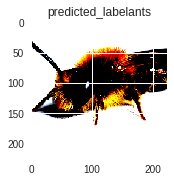

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ants


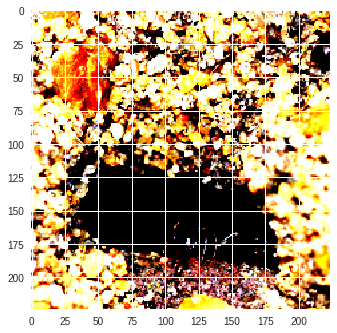

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


bees


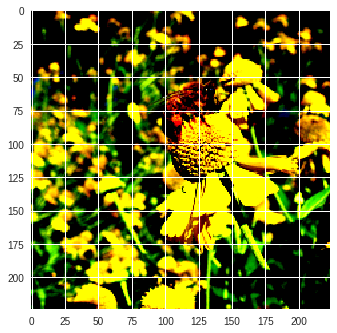

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ants


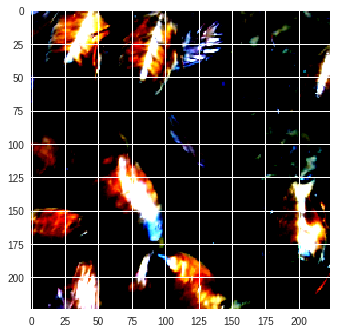

In [119]:
#Visualization
fig=plt.figure()
batch=0
index=0
model.eval()
with torch.no_grad():
  correct=0
  for k,(inputs, labels) in enumerate(dataloaders['val']):
    if batch==1:
      break
    batch+=1  
    inputs=Variable(inputs).cuda()
    labels=Variable(labels).cuda()
    output=model(inputs)
    _, predicted=torch.max(output, 1)
    for i in range(0,4):
      
      ax=fig.add_subplot(2,2,k+1)
      #ax=axis('off')
      ax.set_title('predicted_label{}'.format(class_names[predicted[i]]))
      print(class_names[predicted[i]])
      img=inputs.cpu().data[i]
      img=img.numpy().transpose((1,2,0))
      #print(img.shape)
      mean=np.array([0.485,0.456,0.406])
      std=np.array([0.229,0.224,0.225])
      img1=std * img + mean
      img1=np.clip(img1,0,1)
      #print(img1.shape)
      plt.imshow(img)
      plt.show()
      index+=1
      

In [0]:
119072/4
